In [1]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [2]:
dataset_filepath = 'dataset/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)
df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


In [3]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']
univariate_df.head()

Formatted Date
2006-04-01 00:00:00.000 +0200    9.472222
2006-04-01 01:00:00.000 +0200    9.355556
2006-04-01 02:00:00.000 +0200    9.377778
2006-04-01 03:00:00.000 +0200    8.288889
2006-04-01 04:00:00.000 +0200    8.755556
Name: Temperature (C), dtype: float64

In [4]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset # 7
    if df_end_idx is None:
        df_end_idx = len(df) - window_size

    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size # 6
        label_start_idx = idx + window_size - label_size # 6
        
        feature = df[idx:feature_end_idx] # 0:6
        label = df[label_start_idx:(idx + window_size)] # 6:7
        
        features.append(feature)
        labels.append(label)

    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)

    return features, labels

In [5]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2

train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(
    univariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

In [6]:
class WeatherForecast(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y

In [7]:
train_dataset = WeatherForecast(
    X_train, y_train
)

val_dataset = WeatherForecast(
    X_val, y_val
)

test_dataset = WeatherForecast(
    X_test, y_test
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)


In [8]:
class WeatherForecastor(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        super(WeatherForecastor, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]  # Take the last time step
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [9]:
embedding_dim = 1
hidden_size = 8

n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForecastor(
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob
).to(device)

In [20]:
lr = 1e-3
epochs = 10

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [16]:
def fit(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())
        
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader, criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [17]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [21]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 6.9996	Val loss: 1.5613
EPOCH 2:	Train loss: 6.8472	Val loss: 1.5872
EPOCH 3:	Train loss: 6.7182	Val loss: 1.5294
EPOCH 4:	Train loss: 6.6437	Val loss: 1.5739
EPOCH 5:	Train loss: 6.5296	Val loss: 1.5498
EPOCH 6:	Train loss: 6.4810	Val loss: 1.5444
EPOCH 7:	Train loss: 6.2991	Val loss: 1.5707
EPOCH 8:	Train loss: 6.1732	Val loss: 1.5688
EPOCH 9:	Train loss: 6.2620	Val loss: 1.5538
EPOCH 10:	Train loss: 6.2109	Val loss: 1.4848


In [22]:
val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  (1.484752089575174, 0.005391394504924832)
Test loss:  (1.2952242134258738, 0.006639692914202718)


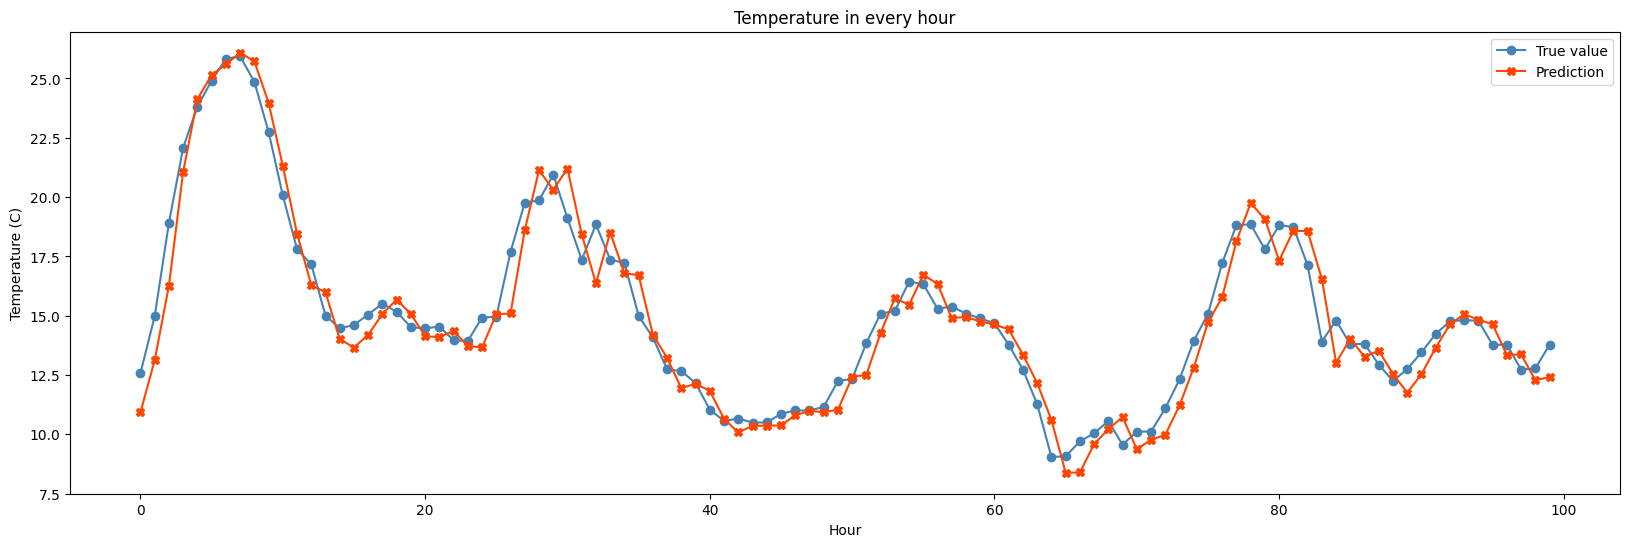

In [23]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Temperature in every hour')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()

plot_difference(y_test[:100], outputs)


In [26]:
def predict_multi_step(model, start_input, steps, device):
    """
    Predict multiple steps using the model and previous outputs as input.
    
    Args:
        model (nn.Module): Trained PyTorch model.
        start_input (np.array or torch.Tensor): Initial input sequence of shape (1, seq_len, embedding_dim).
        steps (int): Number of steps to predict.
        device (str): Device to perform computation on ('cuda' or 'cpu').
    
    Returns:
        list: Predicted values for each step.
    """
    # Ensure the input is a PyTorch tensor and move to the correct device
    if isinstance(start_input, np.ndarray):
        start_input = torch.tensor(start_input, dtype=torch.float32).to(device)
    elif isinstance(start_input, torch.Tensor):
        start_input = start_input.to(device)

    # List to store predictions
    predictions = []

    # Make predictions iteratively
    model.eval()  # Ensure model is in evaluation mode
    with torch.no_grad():
        input_seq = start_input.clone()  # Clone to avoid modifying the original input
        for _ in range(steps):
            # Predict the next value
            output = model(input_seq).detach().cpu().numpy()  # Get model output
            predictions.append(output.flatten()[0])  # Store the prediction (assume scalar output)

            # Append the prediction to the input sequence
            output_tensor = torch.tensor(output, dtype=torch.float32).to(device)
            input_seq = torch.cat([input_seq[:, 1:, :], output_tensor.unsqueeze(1)], dim=1)  # Shift and append

    return predictions

In [27]:
initial_input = X_test[0:1]  # Shape: (1, seq_len, embedding_dim)
steps = 100  # Number of steps to predict

In [28]:
multi_step_predictions = predict_multi_step(
    model,
    start_input=initial_input,
    steps=steps,
    device=device
)

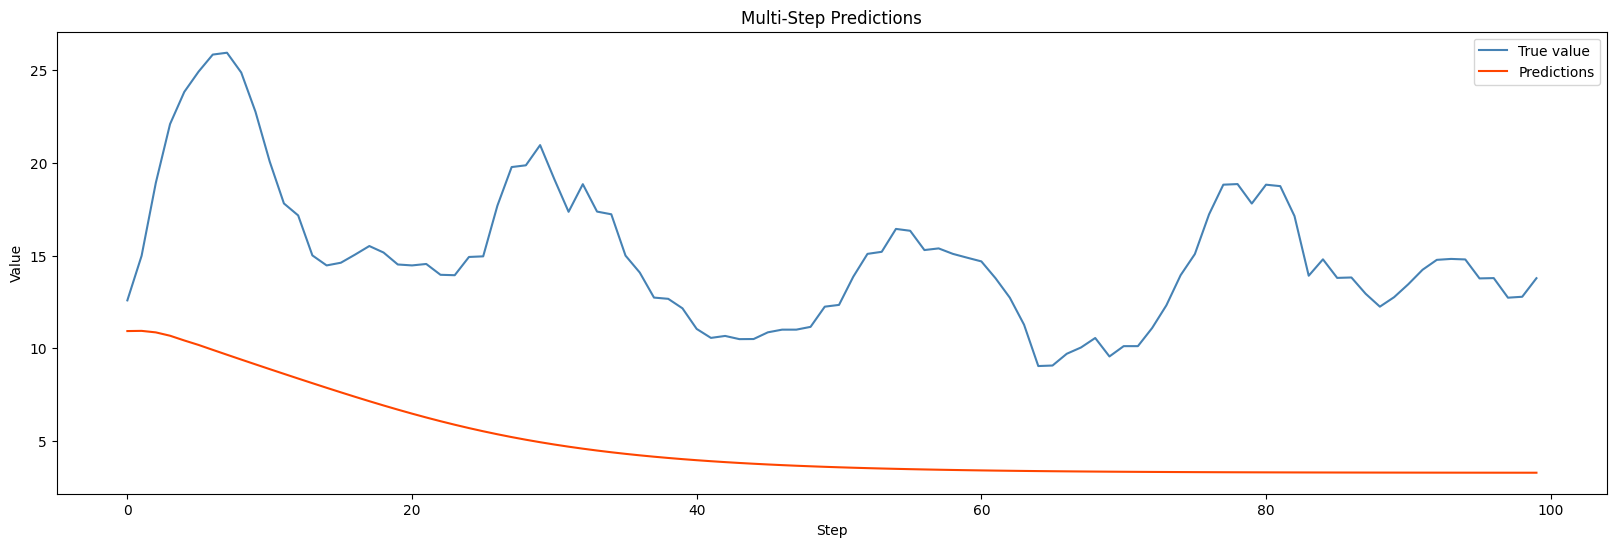

In [30]:
# plot the original data and the predictions
plt.figure(figsize=(20, 6))
plt.plot(range(len(y_test[:steps])), y_test[:steps], label='True value', color='steelblue')
plt.plot(range(len(multi_step_predictions)), multi_step_predictions, label='Predictions', color='orangered')
plt.title('Multi-Step Predictions')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()
plt.show()